### Acknowledgement
This notebook is a Python Notebook version of the great tutorial by Jason Brownlee, PhD at https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ 

### LSTM Intuition
A whole class of problems in machine learning revolves around the fact that the data is connected via time and sequence i.e. the data has dependencies when certain patterns are observed in time or in terms of sequence of values. LSTMs are special networks that can __remember__ and learn __long term dependencies__

### Problem Statement
We have been provided historical data about the number of interntional airline passengerse in units of 1000s between Jan 1949 and Dec 1960 (12 years, 144 observations). The task at hand is to predict the number of passenters in units of 1000s.

In [62]:
import pandas
import io
import matplotlib.pyplot as plt

### Instead of reading from a file, just embedding the data directly into the notebook since it is fairly small set.

In [63]:
content = '''\
"Month","International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
"1949-06",135
"1949-07",148
"1949-08",148
"1949-09",136
"1949-10",119
"1949-11",104
"1949-12",118
"1950-01",115
"1950-02",126
"1950-03",141
"1950-04",135
"1950-05",125
"1950-06",149
"1950-07",170
"1950-08",170
"1950-09",158
"1950-10",133
"1950-11",114
"1950-12",140
"1951-01",145
"1951-02",150
"1951-03",178
"1951-04",163
"1951-05",172
"1951-06",178
"1951-07",199
"1951-08",199
"1951-09",184
"1951-10",162
"1951-11",146
"1951-12",166
"1952-01",171
"1952-02",180
"1952-03",193
"1952-04",181
"1952-05",183
"1952-06",218
"1952-07",230
"1952-08",242
"1952-09",209
"1952-10",191
"1952-11",172
"1952-12",194
"1953-01",196
"1953-02",196
"1953-03",236
"1953-04",235
"1953-05",229
"1953-06",243
"1953-07",264
"1953-08",272
"1953-09",237
"1953-10",211
"1953-11",180
"1953-12",201
"1954-01",204
"1954-02",188
"1954-03",235
"1954-04",227
"1954-05",234
"1954-06",264
"1954-07",302
"1954-08",293
"1954-09",259
"1954-10",229
"1954-11",203
"1954-12",229
"1955-01",242
"1955-02",233
"1955-03",267
"1955-04",269
"1955-05",270
"1955-06",315
"1955-07",364
"1955-08",347
"1955-09",312
"1955-10",274
"1955-11",237
"1955-12",278
"1956-01",284
"1956-02",277
"1956-03",317
"1956-04",313
"1956-05",318
"1956-06",374
"1956-07",413
"1956-08",405
"1956-09",355
"1956-10",306
"1956-11",271
"1956-12",306
"1957-01",315
"1957-02",301
"1957-03",356
"1957-04",348
"1957-05",355
"1957-06",422
"1957-07",465
"1957-08",467
"1957-09",404
"1957-10",347
"1957-11",305
"1957-12",336
"1958-01",340
"1958-02",318
"1958-03",362
"1958-04",348
"1958-05",363
"1958-06",435
"1958-07",491
"1958-08",505
"1958-09",404
"1958-10",359
"1958-11",310
"1958-12",337
"1959-01",360
"1959-02",342
"1959-03",406
"1959-04",396
"1959-05",420
"1959-06",472
"1959-07",548
"1959-08",559
"1959-09",463
"1959-10",407
"1959-11",362
"1959-12",405
"1960-01",417
"1960-02",391
"1960-03",419
"1960-04",461
"1960-05",472
"1960-06",535
"1960-07",622
"1960-08",606
"1960-09",508
"1960-10",461
"1960-11",390
"1960-12",432

International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
'''

### Original data plotted as a graph

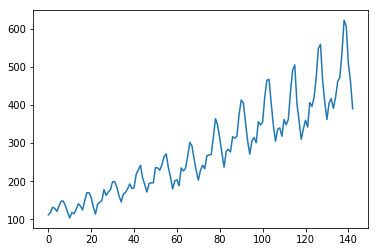

In [64]:
#instead of using the file read, we use String read to read the data. We skip the header and the footer.
dataframe = pandas.read_csv(io.StringIO(content), usecols=[1], engine='python', skipfooter=3)

plt.plot(dataframe)
plt.show()

### LSTM for Regression
We can phrase the problem as a regression problem. That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

In [65]:
# Import all the libraries required.
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [66]:
# Utility function to convert an array of values into a dataset matrix
# It takes the look_back variable as a parameter which specified the
# previous number of time steps used as the input variables to predict
# the next time period.
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [67]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [68]:
# load the dataset
dataset = dataframe.values
dataset = dataset.astype('float32')

#### Normalizing the data set
LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library


In [69]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Splitting the data into training and testing sets
With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [70]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

95 48


In [71]:
# reshape into X=t and Y=t+1. Essentially, the function create_dataset we created earlier, on a look_back factor of 1
# simply creates a pattern of X=t and Y=t+1 pattern
#. e.g.
# X       Y
# 112    118
# 118    132
# 132    129
# 129    121
# 121    135
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [72]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [73]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0395
Epoch 2/100
 - 0s - loss: 0.0191
Epoch 3/100
 - 0s - loss: 0.0144
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0112
Epoch 7/100
 - 0s - loss: 0.0101
Epoch 8/100
 - 0s - loss: 0.0091
Epoch 9/100
 - 0s - loss: 0.0082
Epoch 10/100
 - 0s - loss: 0.0072
Epoch 11/100
 - 0s - loss: 0.0063
Epoch 12/100
 - 0s - loss: 0.0054
Epoch 13/100
 - 0s - loss: 0.0046
Epoch 14/100
 - 0s - loss: 0.0039
Epoch 15/100
 - 0s - loss: 0.0034
Epoch 16/100
 - 0s - loss: 0.0030
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0023
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0020
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0020
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0021
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [74]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.65 RMSE
Test Score: 48.13 RMSE


We can see that the model did an excellent job of fitting both the training and the test datasets.

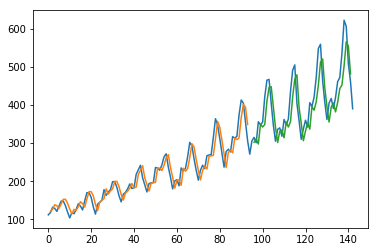

In [75]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression Using the Window Method
We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

We can re-run the example in the previous section with the larger window size. The relevant code listing with just the window size change is listed below for completeness.

In [76]:
# A sample of the dataset with this formulation looks as follows:
# X1     X2     X3     Y
# 112    118    132    129
# 118    132    129    121
# 132    129    121    135
# 129    121    135    148
# 121    135    148    148

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions


Epoch 1/100
 - 2s - loss: 0.0242
Epoch 2/100
 - 0s - loss: 0.0088
Epoch 3/100
 - 0s - loss: 0.0073
Epoch 4/100
 - 0s - loss: 0.0063
Epoch 5/100
 - 0s - loss: 0.0055
Epoch 6/100
 - 0s - loss: 0.0049
Epoch 7/100
 - 0s - loss: 0.0044
Epoch 8/100
 - 0s - loss: 0.0041
Epoch 9/100
 - 0s - loss: 0.0040
Epoch 10/100
 - 0s - loss: 0.0038
Epoch 11/100
 - 0s - loss: 0.0038
Epoch 12/100
 - 0s - loss: 0.0037
Epoch 13/100
 - 0s - loss: 0.0037
Epoch 14/100
 - 0s - loss: 0.0037
Epoch 15/100
 - 0s - loss: 0.0036
Epoch 16/100
 - 0s - loss: 0.0036
Epoch 17/100
 - 0s - loss: 0.0035
Epoch 18/100
 - 0s - loss: 0.0036
Epoch 19/100
 - 0s - loss: 0.0033
Epoch 20/100
 - 0s - loss: 0.0033
Epoch 21/100
 - 0s - loss: 0.0034
Epoch 22/100
 - 0s - loss: 0.0033
Epoch 23/100
 - 0s - loss: 0.0033
Epoch 24/100
 - 0s - loss: 0.0033
Epoch 25/100
 - 0s - loss: 0.0033
Epoch 26/100
 - 0s - loss: 0.0033
Epoch 27/100
 - 0s - loss: 0.0032
Epoch 28/100
 - 0s - loss: 0.0032
Epoch 29/100
 - 0s - loss: 0.0031
Epoch 30/100
 - 0s - lo

We can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned: this is just a demonstration of how to frame a prediction problem.

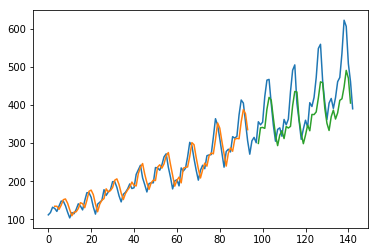

In [77]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression with Time Steps

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. For example:

In [78]:
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


Epoch 1/100
 - 2s - loss: 0.0189
Epoch 2/100
 - 0s - loss: 0.0084
Epoch 3/100
 - 0s - loss: 0.0073
Epoch 4/100
 - 0s - loss: 0.0061
Epoch 5/100
 - 0s - loss: 0.0053
Epoch 6/100
 - 0s - loss: 0.0046
Epoch 7/100
 - 0s - loss: 0.0041
Epoch 8/100
 - 0s - loss: 0.0039
Epoch 9/100
 - 0s - loss: 0.0038
Epoch 10/100
 - 0s - loss: 0.0035
Epoch 11/100
 - 0s - loss: 0.0035
Epoch 12/100
 - 0s - loss: 0.0035
Epoch 13/100
 - 0s - loss: 0.0034
Epoch 14/100
 - 0s - loss: 0.0035
Epoch 15/100
 - 0s - loss: 0.0035
Epoch 16/100
 - 0s - loss: 0.0033
Epoch 17/100
 - 0s - loss: 0.0033
Epoch 18/100
 - 0s - loss: 0.0033
Epoch 19/100
 - 0s - loss: 0.0034
Epoch 20/100
 - 0s - loss: 0.0033
Epoch 21/100
 - 0s - loss: 0.0034
Epoch 22/100
 - 0s - loss: 0.0033
Epoch 23/100
 - 0s - loss: 0.0033
Epoch 24/100
 - 0s - loss: 0.0032
Epoch 25/100
 - 0s - loss: 0.0032
Epoch 26/100
 - 0s - loss: 0.0033
Epoch 27/100
 - 0s - loss: 0.0034
Epoch 28/100
 - 0s - loss: 0.0032
Epoch 29/100
 - 0s - loss: 0.0032
Epoch 30/100
 - 0s - lo

We can see that the results are slightly better than previous example, although the structure of the input data makes a lot more sense.

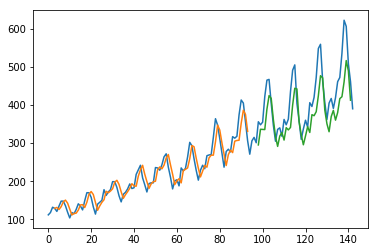

In [79]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM with Memory Between Batches
The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states()

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

In [80]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/1
 - 2s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0060
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/1
 - 0s - loss: 0.0031
Epoch 1/

We do see that results are worse. The model may need more modules and may need to be trained for more epochs to internalize the structure of the problem.

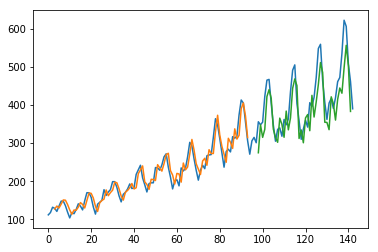

In [81]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Stacked LSTMs with Memory Between Batches

Finally, we will take a look at one of the big benefits of LSTMs: the fact that they can be successfully trained when stacked into deep network architectures.

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True.

In [82]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


Epoch 1/1
 - 3s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0222
Epoch 1/1
 - 0s - loss: 0.0133
Epoch 1/1
 - 0s - loss: 0.0092
Epoch 1/1
 - 0s - loss: 0.0069
Epoch 1/1
 - 0s - loss: 0.0059
Epoch 1/1
 - 0s - loss: 0.0056
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0055
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/1
 - 0s - loss: 0.0054
Epoch 1/

The predictions on the test dataset are again worse. This is more evidence to suggest the need for additional training epochs.

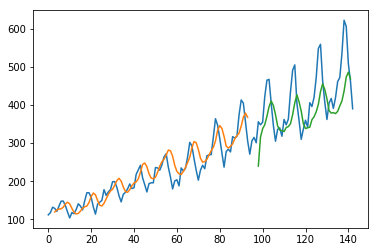

In [83]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Summary

In this post, you discovered how to develop LSTM recurrent neural networks for time series prediction in Python with the Keras deep learning network.

Specifically, you learned:

About the international airline passenger time series prediction problem.
How to create an LSTM for a regression and a window formulation of the time series problem.
How to create an LSTM with a time step formulation of the time series problem.
How to create an LSTM with state and stacked LSTMs with state to learn long sequences.